In [45]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec
from nilearn.connectome import ConnectivityMeasure
from matplotlib import cm
from matplotlib.colors import Normalize

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature


# Load behavioral data

In [46]:
# load data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study'] = 'bochum'
df_essen['study'] = 'essen'
df_szeged['study'] = 'szeged'
df = pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df = df.reset_index()

df = df[df.study == 'essen']

# Compute connectivity

Region names:
 ['GlobSig' 'CER6_p' 'CER7ab' 'R_CERCR2_p' 'CER9_v' 'CER6_a' 'L_CERCR2_a'
 'CER9_d' 'CER9_m' 'CER7b_m' 'L_CERCR2_p' 'CER7b_l' 'N' 'CERCR1' 'CER6_d'
 'CER5' 'R_CERCR2_a' 'POsul_d' 'POsul_v' 'VMPFcor_p' 'R_MTgyr_a'
 'L_ANGgyr' 'L_MTgyr_p' 'L_MTgyr_a' 'DMPFC_ar' 'L_SFsul_a' 'DMPFcor_ac'
 'PCcor' 'POsul' 'L_IPlob' 'PGACcor' 'VMPFcor_a' 'PRC_d' 'SFgyr_ad'
 'L_IPlob.1' 'R_ANGgyr' 'PRC_v' 'R_MTgyr_p' 'PRC_d.1' 'R_MFgyr_a'
 'L_DVIS_v' 'SPlob' 'R_VLPFcor' 'FUSgyr_vl' 'R_IFsul' 'FP' 'R_DVIS_v'
 'L_FP_l' 'SPlob.1' 'L_MFgyr_pc' 'L_VLPFcor' 'OCCTgyr_l' 'ACcor_d'
 'L_MFgyr_pr' 'R_MFgyr_p' 'R_IPsul' 'L_IFsul' 'DVIS_s' 'FUSgyr_dl'
 'R_SFsul' 'R_IPlob' 'R_FP_l' 'R_PORB' 'DMPFcor_p' 'L_IPsul' 'L_MFgyr_a'
 'DVIS_vl' 'CAUDNH_NACC' 'COLsul' 'LORBgyr' 'ITgyr' 'STgyr_a' 'MORBgyr'
 'PINS_v' 'TP' 'HIPP' 'AMY' 'PIsul' 'CERVM' 'L_MOTnet_dl' 'MOTnet_am'
 'R_MOTnet_dl' 'MOTnet_m' 'MOTnet_ml' 'MOTnet_vl' 'MOTnet_l' 'l_PCsul'
 'CNGsul_p' 'PUT_p' 'AINS_pd' 'CAUDN_d' 'AINS_v' 'FEF' 'PCsul_d' 'IMsul'
 'ST

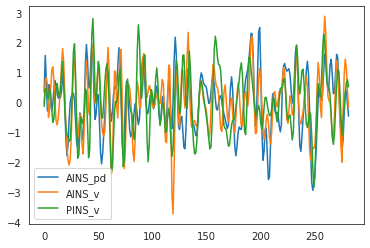

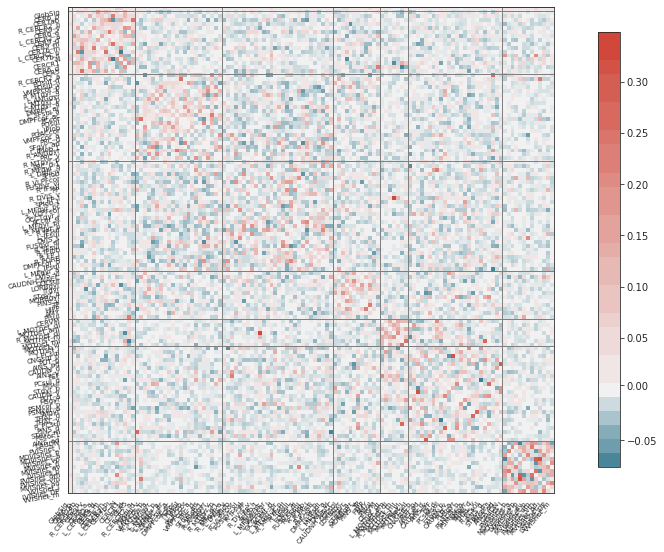

In [47]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'

    ts = pd.read_csv(f_scrub).iloc[:, 1:]  # here we can omit global signal...

    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd

    perc_scrubbed.append(100 - 100 * len(ts.shape) / len(fd))
    timeseries.append(ts.values)

# double check visually
sub_idx = 10  # modify this for a different subject
# modify below for different regions (see the next cell for region names)
pd.DataFrame(timeseries[sub_idx], columns=ts.columns.values).loc[:, ['AINS_pd', 'AINS_v', 'PINS_v']].plot()
## Load region and module names for the MIST122 atlas
labels = ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules = np.insert(l['modules'].values, 0, "GlobSig")
print('Region names:\n', labels)
## Calculate functional connectivity as partial correlation
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=False)
X = correlation_measure.fit_transform(timeseries)  # these are the features
joblib.dump(X, "../res/multi-center/all_features.joblib")

# double-check the mean matrix visually
mat = correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0  # zero diag
plot.plot_matrix(mat, labels, modules)

In [48]:
X.shape

(37, 123, 123)

# Load participant-level connectivity data

In [49]:
mc_model = pd.read_csv('../res/multi-center/finalized_model_connections.csv')
#mc_model = mc_model[mc_model['abs_multi-center']>0.02]
conns_mc_model = np.zeros((X.shape[0], len(mc_model)))
for idx, (i_a, i_b) in enumerate(zip(mc_model.idx_A, mc_model.idx_B)):
    #conns_mc_model(i_a, i_b)
    conns_mc_model[:, idx] = X[:, i_a, i_b]
conns_mc_model = pd.DataFrame(conns_mc_model, columns=mc_model.connectivity)
conns_mc_model

connectivity,GlobSig - VMPFcor_p,CER6_p - MORBgyr,CER6_p - PSMcor_p,CER7ab - CAUDNH_NACC,R_CERCR2_p - R_CERCR2_a,R_CERCR2_p - STgyr_a,R_CERCR2_p - AINS_v,R_CERCR2_p - PVISnet_dm,L_CERCR2_a - R_MTgyr_a,CER9_d - L_MFgyr_pc,...,MOTnet_m - MVISnet_p,MOTnet_m - LVISnet_p,PUT_p - STgyr_p,AINS_pd - PUT_a,AINS_pd - MDVISnet_p,AINS_v - MVISnet_ad,FEF - IMsul,STgyr_p - LVISnet_DP,THAL_d - PCcor.1,THAL_v - PINS_d
0,0.020339,0.134190,-0.024640,-0.006932,0.345525,0.030598,-0.071552,-0.000886,0.002566,0.031245,...,0.053698,0.080987,-0.007720,-0.000955,-0.018291,0.022215,0.065498,0.007405,0.012989,0.052162
1,0.022736,-0.111256,-0.067071,-0.018952,0.266637,0.042836,-0.024951,0.018903,0.078971,0.000611,...,0.045942,-0.007104,0.026179,-0.015392,0.038517,-0.042379,-0.005738,-0.028688,0.122297,0.009331
2,0.019064,-0.114666,-0.067455,-0.028233,0.240898,0.080626,-0.025701,0.002694,0.089153,0.007236,...,0.050745,-0.011732,0.009806,-0.023525,0.031011,-0.038378,-0.001509,-0.047653,0.121469,0.003318
3,0.036628,0.074340,0.089518,0.087431,0.164033,0.031577,0.046481,-0.050528,0.135477,-0.045227,...,0.010448,0.063602,0.038584,0.011670,-0.078165,-0.043755,0.029956,-0.002152,0.058278,-0.078963
4,0.012235,-0.036881,0.003925,-0.023909,0.212679,0.061581,-0.014289,-0.036912,0.012963,0.075510,...,-0.011474,-0.055411,0.012721,0.012209,-0.017282,0.005614,0.056110,-0.004235,0.034812,-0.172530
5,0.038758,0.062826,0.000247,0.130658,0.263943,-0.089201,0.002865,0.007645,-0.114401,0.038862,...,-0.068364,0.132004,-0.003183,-0.036067,-0.091578,-0.043794,0.092025,-0.042130,0.052745,0.127770
6,-0.000966,-0.085620,0.108357,0.022691,0.204880,-0.043965,0.094371,-0.063001,0.038262,-0.042843,...,-0.015715,-0.039435,0.022942,0.011095,0.038518,-0.088807,-0.046280,-0.008715,-0.219721,-0.032465
7,0.040377,0.011697,0.023987,0.033083,0.293279,-0.001112,0.101294,-0.097326,-0.036086,-0.049292,...,0.008776,-0.001130,0.007765,-0.010430,-0.004020,0.006505,0.069574,0.008561,0.102767,0.153067
8,0.015089,-0.042602,0.015156,0.056696,0.169649,0.051958,-0.059464,0.013560,0.025413,0.001832,...,-0.017844,0.032053,0.000259,0.001080,-0.148089,0.046518,-0.036536,-0.011278,0.022312,0.005129
9,0.020395,-0.006083,-0.026232,-0.003212,0.356227,0.005795,0.093562,-0.185662,-0.025318,0.047446,...,0.094907,0.098248,0.021826,-0.034595,0.025001,-0.038358,0.052026,0.082070,0.084784,0.076182


In [50]:
#vars = df[['Male', 'Age', 'CDT_log_mean', 'WDT_log_mean', 'MDT_log_geom', 'CPT', 'HPT', 'MPT_log_geom', 't50', 'psq', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'anx_state', 'anx_trait', 'PSQ20', 'ads_k', 'Glx_mean', 'GABA_mean', 'meanFD', 'maxFD', 'medianFD', 'BP_MRI_sys', 'BP_MRI_dias', 'BP_QST_sys', 'BP_QST_dias' ]]
df2 = df.copy()
df2['nHPT'] = df.HPT * -1
df2['nMPT'] = df.MPT_log_geom * -1
df2['nt50'] = df.t50 * -1
df2['npsq'] = df.psq * -1
df2['nanx_state'] = df.anx_state * -1
df2['nanx_trait'] = df.anx_trait * -1

vars = df2[['CPT', 'nHPT', 'nMPT', 'nt50', 'npsq', 'nanx_state', 'nanx_trait', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'PSQ20', 'ads_k', 'Glx_mean', 'GABA_mean' ]]

vars.corrwith(df.mean_QST_pain_sensitivity)


CPT                    0.737169
nHPT                   0.795681
nMPT                   0.618408
nt50                        NaN
npsq                   0.074496
nanx_state             0.043589
nanx_trait            -0.098512
pcs_catastrophizing    0.044636
pcs_rumination              NaN
PSQI                   0.130261
PSQ20                  0.059134
ads_k                  0.064367
Glx_mean                    NaN
GABA_mean                   NaN
dtype: float64

In [51]:
corrmtx = np.zeros((vars.shape[1], conns_mc_model.shape[1]))

for i in range(vars.shape[1]):
    for j in range(conns_mc_model.shape[1]):
        mask = ~np.isnan(vars.values[:,i]) & ~np.isnan(conns_mc_model.values[:,j])
        corrmtx[i, j] = np.corrcoef(vars.values[mask,i], conns_mc_model.values[mask,j])[0,1]
corrmtx = pd.DataFrame(corrmtx, columns=conns_mc_model.columns, index=vars.columns)
corrmtx

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


connectivity,GlobSig - VMPFcor_p,CER6_p - MORBgyr,CER6_p - PSMcor_p,CER7ab - CAUDNH_NACC,R_CERCR2_p - R_CERCR2_a,R_CERCR2_p - STgyr_a,R_CERCR2_p - AINS_v,R_CERCR2_p - PVISnet_dm,L_CERCR2_a - R_MTgyr_a,CER9_d - L_MFgyr_pc,...,MOTnet_m - MVISnet_p,MOTnet_m - LVISnet_p,PUT_p - STgyr_p,AINS_pd - PUT_a,AINS_pd - MDVISnet_p,AINS_v - MVISnet_ad,FEF - IMsul,STgyr_p - LVISnet_DP,THAL_d - PCcor.1,THAL_v - PINS_d
CPT,0.229675,0.110302,-0.154503,0.353465,0.139328,-0.092692,-0.317535,0.487172,-0.120496,0.182459,...,-0.232336,0.085977,0.292600,-0.101493,-0.419929,0.133004,0.303029,-0.051696,0.168241,0.093365
nHPT,0.262973,0.456598,-0.135249,0.417716,0.275462,-0.300602,-0.093144,0.351376,-0.077119,0.188897,...,-0.047865,0.421290,0.195411,-0.373648,-0.058168,-0.081970,0.328041,0.172355,0.273023,0.267028
nMPT,0.221615,0.191251,-0.278457,-0.108166,-0.040300,-0.193063,-0.012083,0.057867,-0.299795,0.112922,...,0.071442,0.384346,0.116498,-0.256611,-0.215843,0.004053,0.142599,0.109908,0.388489,0.369133
nt50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
npsq,-0.033822,-0.142317,0.226448,0.110875,-0.073706,-0.126804,-0.138188,-0.144976,0.115536,-0.134110,...,0.142857,0.075813,0.037536,-0.133252,0.074775,-0.071632,-0.046291,-0.008499,-0.013151,0.011835
nanx_state,0.044010,0.068548,0.081234,0.275227,-0.061274,-0.256967,0.040688,-0.005383,0.142192,-0.011494,...,-0.187792,-0.218453,0.063715,-0.234304,0.083580,-0.044197,0.120363,-0.077554,0.177817,-0.109750
nanx_trait,0.220227,0.021110,0.326820,0.118588,-0.068571,-0.204456,0.183047,-0.224122,-0.010576,0.013564,...,0.040072,-0.091535,0.175397,-0.329960,0.004700,-0.203935,-0.108946,-0.035533,0.025417,-0.121495
pcs_catastrophizing,-0.116061,0.030927,-0.067237,-0.200529,0.015481,0.326477,-0.083004,0.116575,-0.006610,-0.013586,...,-0.127258,-0.006445,-0.107748,0.344985,-0.081581,-0.025250,0.092980,0.252803,-0.166557,0.060987
pcs_rumination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PSQI,-0.196273,0.026123,-0.253391,-0.141002,0.031345,-0.169088,-0.268443,0.390548,0.033142,-0.008814,...,0.035968,0.211777,-0.045189,0.120803,-0.284653,0.198084,-0.247788,-0.017312,0.014680,0.001868


<AxesSubplot:ylabel='connectivity'>

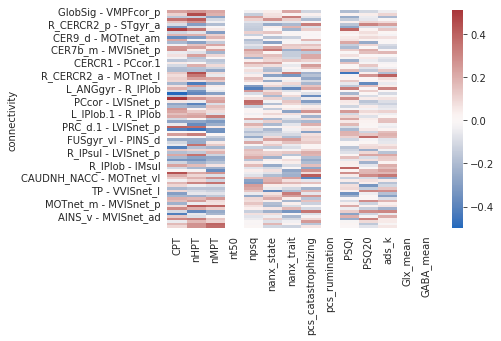

In [52]:
sns.heatmap(corrmtx.T, cmap=sns.color_palette("vlag", as_cmap=True))

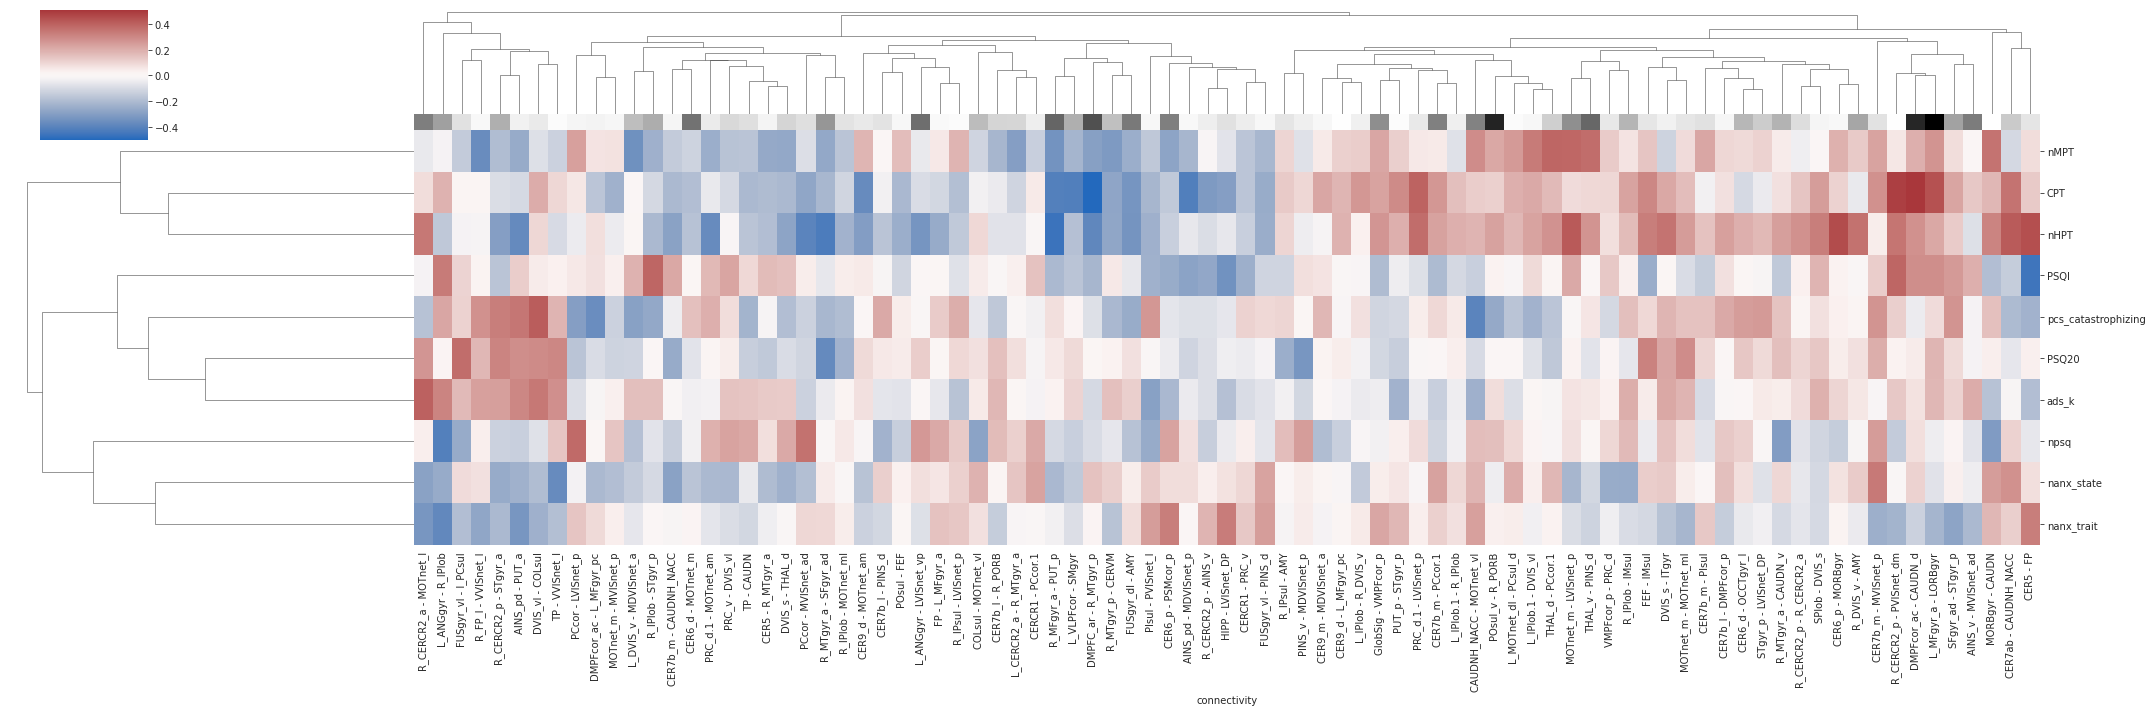

In [53]:
norm = Normalize()
sns.clustermap(corrmtx.dropna(), cmap="vlag", figsize=(30,10), col_colors=cm.binary(norm(mc_model['abs_multi-center'])))

In [54]:
#Importing libraries
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram , linkage

In [55]:
#Linkage Matrix
Z = linkage(corrmtx.T, method = 'ward')
#plotting dendrogram
plt.figure(figsize=(20,10))
dendro = dendrogram(Z, labels=corrmtx.columns)
plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.xticks(fontsize = 12)
plt.show()


ValueError: The condensed distance matrix must contain only finite values.

In [ ]:
Z=pd.DataFrame(Z, index=corrmtx.columns)

In [ ]:
corrmtx.shape

In [ ]:
Z